In [1]:
import numpy as np 
import pandas as pd 
import xgboost as xgb
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ParameterGrid
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# load the data
df = pd.read_csv("../data/data.csv")
df.columns = ['news_id', 'description']
print(df.head())
print(df.info())

   news_id                                        description
0    96100   DUBAI (Reuters) - The group led by al Qaeda a...
1   116223   SANTA MONICA, Calif. (Reuters) - The stars of...
2    17386  AP - A week of rallies, marches and nearly 1,8...
3     3808   SRINAGAR, India (Reuters) - Indian soldiers k...
4   108622  The U.S. Supreme Court has agreed to review an...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
news_id        10000 non-null int64
description    10000 non-null object
dtypes: int64(1), object(1)
memory usage: 156.3+ KB
None


# Processing the text and clustering

In [3]:
# preprocessing

print(df[df['description'].duplicated(keep=False)].sort_values('description').head(8))
df_cleaned = df.drop_duplicates('description') # check if duplicate, and drop if any
print(df_cleaned.info()) # there are 7 duplicated records

df_cleaned['description'] = df_cleaned['description'].str.lower() # make all description lower case

df_cleaned['description'] = df_cleaned['description'].str.replace('\d+', '') # remove all numbers

print(df_cleaned.sample(5))

      news_id                                        description
7325    71471   AMSTERDAM (Reuters) - Lakshmi Mittal, one of ...
8465    71699   AMSTERDAM (Reuters) - Lakshmi Mittal, one of ...
3324    53033   CHICAGO (Reuters) - Wal-Mart Stores Inc. &lt;...
4069    53089   CHICAGO (Reuters) - Wal-Mart Stores Inc. &lt;...
3929   106484  A screensaver developed by Lycos Europe that g...
8111   106361  A screensaver developed by Lycos Europe that g...
700     99544  AP - Apple Computer Inc. stock jumped to a fou...
3628    98899  AP - Apple Computer Inc. stock jumped to a fou...
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9993 entries, 0 to 9999
Data columns (total 2 columns):
news_id        9993 non-null int64
description    9993 non-null object
dtypes: int64(1), object(1)
memory usage: 234.2+ KB
None
      news_id                                        description
8759    35805  motorsport.com. the contract recognition board...
2669   106965  following an apparent attempt on his

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [4]:
# TF-IDF

puncs = ['.', ',', '"', "'", '!', '?', ':', ';', '[', ']', '(', ')', '{', '}',"%"]
stop_words = text.ENGLISH_STOP_WORDS.union(puncs)
desc = df_cleaned['description'].values
vectorizer = TfidfVectorizer(stop_words = stop_words)
X = vectorizer.fit_transform(desc)
word_features = vectorizer.get_feature_names()
print(len(word_features)) # there are a total of 21733 initial word_features
print(word_features)

21733
['aa', 'aaa', 'aapl', 'aapt', 'aarde', 'aaron', 'ab', 'ababa', 'abagnale', 'abandon', 'abandoned', 'abandoning', 'abare', 'abbas', 'abbey', 'abboud', 'abc', 'abdel', 'abdelrahman', 'abdicated', 'abducted', 'abducting', 'abduction', 'abductors', 'abdul', 'abdullah', 'abercrombie', 'aberdeen', 'abidjan', 'ability', 'abimael', 'abkhazia', 'able', 'abn', 'abnormal', 'aboard', 'abolish', 'abolishing', 'abonns', 'aborted', 'abortion', 'abortions', 'abortive', 'aboud', 'abounds', 'abraham', 'abramovich', 'abroad', 'abrupt', 'abruptly', 'abs', 'absa', 'absence', 'absent', 'absolute', 'absolutely', 'absolved', 'absorb', 'absorbed', 'absorbs', 'absurdly', 'abu', 'abuja', 'abul', 'abullah', 'abuse', 'abused', 'abuses', 'abusing', 'abusive', 'abuzz', 'abyss', 'ac', 'acacia', 'academic', 'academics', 'academies', 'academy', 'acc', 'accelerate', 'accelerated', 'accelerates', 'accelerating', 'accept', 'acceptable', 'accepted', 'accepting', 'accepts', 'access', 'accessed', 'accessibility', 'acce

In [5]:
# tokenization and stemming
# use the stemming to

stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]

vectorizer_2 = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize)
X_2 = vectorizer_2.fit_transform(desc)

vectorizer_3 = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize, max_features = 1000)
X_3 = vectorizer_3.fit_transform(desc)
words = vectorizer_3.get_feature_names()
# limit the word features at 1000
print(len(words))
print(np.shape(X_3))


1000
(9993, 1000)


Text(0,0.5,'WCSS')

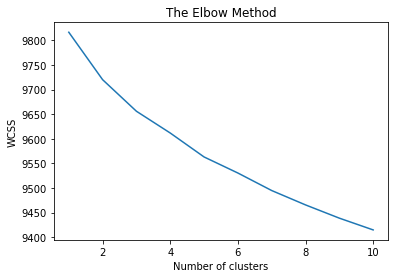

In [10]:
# clustering

# choose # of clusters using the elbow method
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(X_3)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

# judging from the plot, elbows roughly show at cluster # 2,3, and 5

In [11]:
# 2 clusters

kmeans = KMeans(n_clusters = 2, n_init = 20) 
cluster_labels_2c = kmeans.fit_predict(X_3)

common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]

for n, centroid in enumerate(common_words):
    print(str(n) + ' : ' + ', '.join(words[word] for word in centroid))

0 : s, said, new, year, quot, reuter, ap, compani, wednesday, world, monday, tuesday, game, yesterday, week, state, report, thursday, friday, presid, say, day, time, u, nation
1 : lt, gt, fullquot, n, reuter, http, href, www, ticker, quickinfo, aspx, stock, target, com, investor, o, strong, p, b, font, new, york, quarter, said, profit


In [13]:
# 3 clusters

kmeans = KMeans(n_clusters = 3, n_init = 20) 
cluster_labels_3c = kmeans.fit_predict(X_3)

common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]

for n, centroid in enumerate(common_words):
    print(str(n) + ' : ' + ', '.join(words[word] for word in centroid))

0 : s, said, new, year, reuter, ap, compani, wednesday, world, monday, week, tuesday, game, yesterday, state, friday, thursday, report, presid, day, u, say, time, nation, unit
1 : quot, profil, research, s, said, n, new, quarter, yesterday, say, year, game, corp, report, compani, thursday, o, microsoft, tuesday, like, servic, monday, secur, sale, percent
2 : lt, gt, fullquot, n, reuter, http, href, www, ticker, quickinfo, aspx, stock, target, com, investor, o, strong, p, b, font, new, york, quarter, said, profit


In [14]:
# 5 clusters

kmeans = KMeans(n_clusters = 5, n_init = 20) 
cluster_labels_5c = kmeans.fit_predict(X_3)

common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]

for n, centroid in enumerate(common_words):
    print(str(n) + ' : ' + ', '.join(words[word] for word in centroid))

0 : price, oil, quarter, reuter, s, percent, stock, u, sale, profit, year, said, new, report, expect, york, market, share, growth, rate, dollar, rise, wednesday, tuesday, rose
1 : game, season, win, s, team, night, victori, leagu, ap, second, time, olymp, sunday, coach, play, world, champion, saturday, cup, score, new, lead, point, final, player
2 : lt, gt, fullquot, n, reuter, http, href, www, ticker, aspx, quickinfo, stock, target, com, investor, o, strong, p, b, font, new, york, quarter, said, profit
3 : s, said, new, compani, year, presid, reuter, say, ap, peopl, plan, kill, yesterday, state, million, govern, servic, report, offici, wednesday, week, secur, monday, announc, tuesday
4 : quot, profil, research, s, said, n, new, say, year, yesterday, game, corp, quarter, compani, tuesday, microsoft, thursday, report, o, like, servic, secur, monday, percent, wednesday


# Summary of Clustering

    By quickly scanning through the key words listed in each cluster, I think 5 clusters might be a good choice because the topic of each cluster can be summarized from key words:
    cluster 0: about company profit
    cluster 1: about international politics
    cluster 2: about the stock and investment
    cluster 3: stock and investment
    cluster 4: about the sport games
    

# Train a classifier for the news headlines

In [15]:
# combine the dataset and cluster label, split the dataset into training, and test sets
X_train, X_test, y_train, y_test = train_test_split(X_3, cluster_labels_5c, test_size=0.2, random_state=40)

print(np.shape(X_train))
print(np.shape(X_test))

(7994, 1000)
(1999, 1000)


In [16]:
# use xgboost classifier
XGB = xgb.XGBClassifier()
param_grid = {"learning_rate": [0.1],
              "objective":['multi:softmax'],
              "reg_alpha": [0.1],
              "missing": [np.nan], 
              "reg_lambda": [0.1]}

params = ParameterGrid(param_grid)[0]
XGB.set_params(**params)

XGB.fit(X_train, y_train)
y_test_pred = XGB.predict(X_test)

cnf_matrix = confusion_matrix(y_test,y_test_pred)
precision = precision_score(y_test, y_test_pred,average=None)
recall = recall_score(y_test, y_test_pred,average=None)

print('the confusion matrix is:')
print(cnf_matrix)
print('The precision of the model on test set is:', precision)
print('The recall of the model on test set is:', recall)


the confusion matrix is:
[[ 147    1    0   54    0]
 [   1  318    0  128    0]
 [   0    0   43    0    0]
 [   1   12    0 1193    3]
 [   0    0    1    0   97]]
The precision of the model on test set is: [ 0.98657718  0.96072508  0.97727273  0.86763636  0.97      ]
The recall of the model on test set is: [ 0.72772277  0.7114094   1.          0.98676592  0.98979592]


# Summary of the xgboost model
    An gradient-boost model is built to predict the cluster label of each news. The features are the 1000 cleaned vectorized word features, and the target variable (class) is the cluster labels.
    The prediction results are pretty good:
    Most of the news are correctly predicted, sitting on the diagonal of the confusion matrix.
    The precision and recall for classes reached as high as 1. The lowest values of the two metrics are still higher than 0.7.
    The two classes that have some difficulty to be distinguished is class 0 and class 4. The possible reason is that the two classes has a lot pieces of new in them. If given more time, instead of just limit the word features using functions, more careful feature selection is needed.